# Feature Importance

Author: Yi Huang

# Outline
* [Why We Care about Feature Importance](#intro)
* [Spearman Ranking](#Spearman)
* [PCA Ranking](#PCA)
* [Minimal Redundancy Maximal Relevance (mRMR)](#mRMR)
* [Model Based Feature Importance (LightGBM as example)](#model)
    * [Drop Column Importance](#model1)
        * Accuracy
        * Log loss
    * [Permutation Importance](#model2)
        * Accuracy
        * Log loss
    * [LightGBM Default](#model3)
    * [SHAP](#model4)
* [Methods Comparison](#compare)
* [Automatic Feature Searching](#automatic)
* [Conclusion](#Conclusion)
* [Reference](#Reference)

In [1]:
import pandas as pd
import numpy as np
from   sklearn.model_selection import train_test_split
import optuna
from optuna._imports import try_import
from optuna.integration import _lightgbm_tuner as tuner
from sklearn.model_selection import KFold
import lightgbm as lgb
from lightgbm import LGBMClassifier
from featimp import * 
import shap

import warnings
warnings.filterwarnings('ignore')

# Why we care about feature importance? <a class="anchor" id="intro"></a>

* Feature Selection: Algorithms like tree based models (e.g. LightGBM, XGBoost) can handle a large amount of features pretty well without feature selection, whereas feature selection is still extremely helpful. 1. Many features will introduce noise into the dataset, in such case your models are likely to overfit and give you a false feeling of good performance. 2. It will reduce the running time of training your algorithm, as well as meet the low latency requirement after deploying your model into use. 3. More comprehendible to humans. Feature importance facilitates choosing the right features.
* Explanatory Analysis: Machine learning is not always about higher prediction power, sometimes we want to open the blackbox and see the underlying secrets about the data. Explanatory analysis is becoming more and more important in the data science world. It's an essential tool to find the key players in your analysis. Feature importance helps you find these key features and their relationship with the target variable.

### Load data (already preprocessed) <br>
This dataset is from a public Kaggle dataset. I already cleaned this dataset and downsampled it in order to have better performance for this feature importance project. <br>

The reason why I choose this dataset: In financial companies, feature importance is critical for guiding the risk management, marketing strategy, customer management, etc. People want to know what are the <b>"North Star"</b> factors influence their businesses. <br>

Dataset Link: https://www.kaggle.com/mlg-ulb/creditcardfraud <br>

In [2]:
df = pd.read_csv('creditcard_down.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


In [35]:
df.Class.value_counts()

0    4920
1     492
Name: Class, dtype: int64

This dataset contains 30 features, 28 of which are unknown features. Class column is the label, where 0 means non-fraud and 1 means fraud.

Now let's open the door of feature importance. We will talk about following feature importance methods:
* Spearman
* PCA
* mRMR
* Model Based
    * Drop Column Importance with accuracy
    * Drop Column Importance with log loss
    * Permutation Importance with accuracy
    * Permutation Importance with log loss
    * LightGBM default: feature_imp
    * Shap: feature_importance

Then we will compare the performance of these methods. The best one will be used for our automatic feature searching algorithm.

# Spearman Ranking <a class="anchor" id="Spearman"></a>

Spearman Correlation is a rank based Pearson Correlation method. We calculate each variable and it's correlation with target variable. This methods ignore the multicollinearity problem, some features with similar information will have the same importance. 

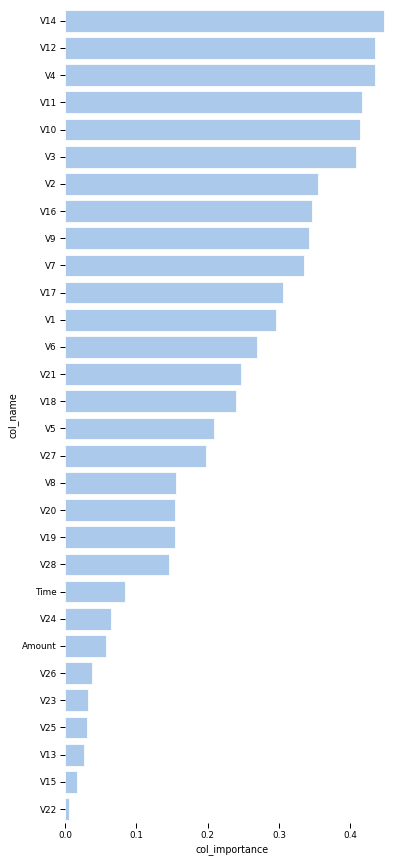

In [5]:
importance_spearman = spearman_ranking(df,'Class',absolute = True)
importance_plot(importance_spearman)

# PCA Ranking <a class="anchor" id="PCA"></a>

PCA can also used to find features with the most information. This methods only explore the information carried by all independent variables (X). The hypothesis is that if the first component carries most information, then the weight of each feature can explain it's importance. Here we extract the first component after dimension reduction. Each feature's importance is just it's weight from the first component.

Explained variance for the first component:0.3007450183478879


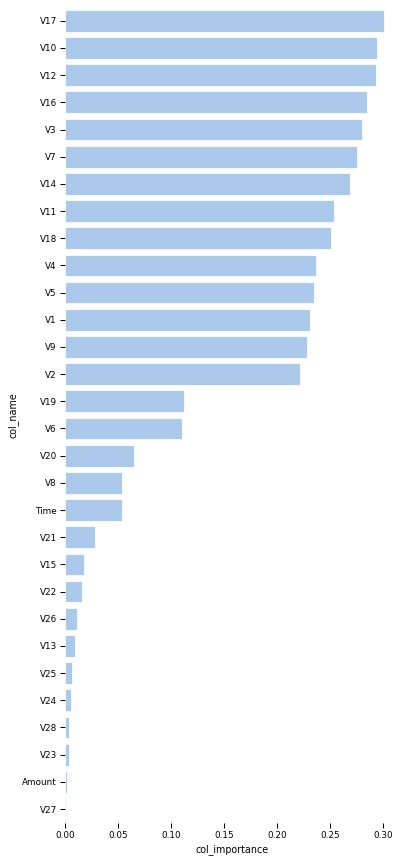

In [6]:
importance_pca = pca_ranking(df,'Class',absolute = True)
importance_plot(importance_pca)

For this particular problem, only 30% of feature's information is explained by the first component. We might need to have a second thought about this result.

# Minimal Redundancy Maximal Relevance (mRMR) <a class="anchor" id="mRMR"></a>

This method considers correlation with target variable and other features. The formula is as follows:

<h2><center>$f^{mRMR}(X_{i}) = I(Y,X_{i}) - \frac{1}{\left | S \right |}\sum_{X_{s}\in S}^{}I(X_{s},X_{i})$</center></h2>

- Y is the target variable
- I ( ) is the correlation calculation (e.g. mutual information, spearman correlation). For this notebook, I use the <b>Spearman Correlation</b>. 
- S is the size of features minus 1.
- Xs is all features except the one for calculation.

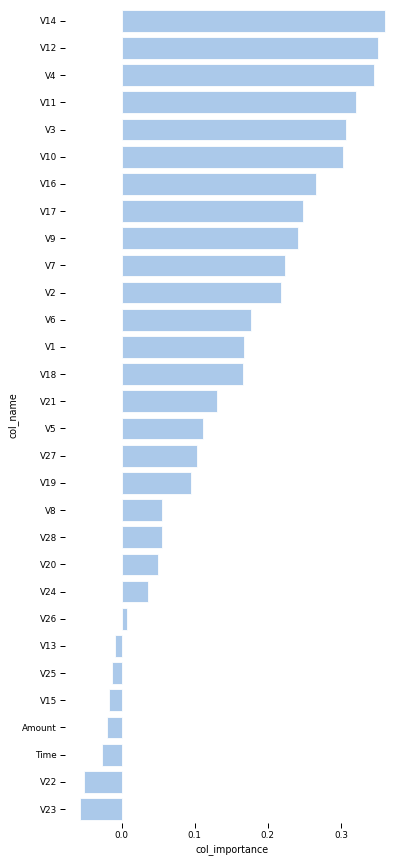

In [7]:
importance_mRMR = mrmr_ranking(df,'Class')
importance_plot(importance_mRMR)

# Model Based Ranking (LightGBM as example)  <a class="anchor" id="model"></a>

Some models have build-in feature importance. The default feature importance for random forest might be misleading, here I borrow and test the idea of <b>permutation importance</b> and <b>drop column importance</b>. <br>
Here is an link to the article: https://explained.ai/rf-importance/index.html
In this part, we implement for different model based feature importance methods:
* Drop column
* Permutation
* LGBM default
* SHAP

### Model Training with Optuna

First we train the best model with all features using LightGBM and Optuna as hypterparameter tuning method.

In [8]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
# Split data with balanced class
X_train, X_valid, y_train, y_valid = train_test_split(X, y,random_state = 42,test_size = 0.2,stratify=y)

In [9]:
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)

In [10]:
def objective(trial, return_info=False):
    folds = 5
    seed = 42
    shuffle = True
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        #'learning_rate': 0.1,
        'verbosity': -1,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth':trial.suggest_int('max_depth',5,15)
    }

    
    models = []
    valid_score = 0
    losses = []
    for train_idx, valid_idx in kf.split(X_train, y_train):
        train_x,train_y = X_train.iloc[train_idx,:], y_train[train_idx]
        valid_x,valid_y = X_train.iloc[valid_idx,:], y_train[valid_idx]
        d_train = lgb.Dataset(train_x,train_y)
        d_valid = lgb.Dataset(valid_x,valid_y)
        watchlist = [d_train, d_valid]
        early_stop = 20
        verbose_eval = 20
        model = lgb.train(param,
                          train_set=d_train,
                          num_boost_round=1500,
                          valid_sets=watchlist,
                          verbose_eval=verbose_eval,
                          early_stopping_rounds=early_stop)
        y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
        
        print('best_score', model.best_score)
        log = {'train': model.best_score['training']['binary_logloss'],
               'valid': model.best_score['valid_1']['binary_logloss']} 
        
        models.append(model)
        valid_score += log["valid"]
    valid_score /= len(models)
    
    if return_info:
        return valid_score, models
    else:
        return valid_score
study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2021-05-09 16:11:47,761] A new study created in memory with name: no-name-592225d0-4a56-4a06-9844-fa2b1227bc27


Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0507272	valid_1's binary_logloss: 0.06573
[40]	training's binary_logloss: 0.0150443	valid_1's binary_logloss: 0.0567853
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.0165177	valid_1's binary_logloss: 0.0565588
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.016517735792337708)]), 'valid_1': OrderedDict([('binary_logloss', 0.056558800419588086)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0494324	valid_1's binary_logloss: 0.0667666
[40]	training's binary_logloss: 0.0172871	valid_1's binary_logloss: 0.0547138
[60]	training's binary_logloss: 0.00556194	valid_1's binary_logloss: 0.0595703
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.0155086	valid_1's binary_logloss: 0.0544605
best_score defaultdict(<class 'collections.OrderedDict'>, {'traini

[I 2021-05-09 16:11:48,877] Trial 0 finished with value: 0.06670798357679901 and parameters: {'lambda_l1': 1.4600853313136385e-08, 'lambda_l2': 3.085859593181914e-06, 'num_leaves': 32, 'feature_fraction': 0.8863497661782209, 'bagging_fraction': 0.6184496400408785, 'bagging_freq': 6, 'min_child_samples': 20, 'max_depth': 13}. Best is trial 0 with value: 0.06670798357679901.



best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.025377585388408057)]), 'valid_1': OrderedDict([('binary_logloss', 0.084747072423525)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0568518	valid_1's binary_logloss: 0.06482
[40]	training's binary_logloss: 0.0206714	valid_1's binary_logloss: 0.0498893
[60]	training's binary_logloss: 0.00818582	valid_1's binary_logloss: 0.0503603
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.0161845	valid_1's binary_logloss: 0.0492355
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.016184481898631527)]), 'valid_1': OrderedDict([('binary_logloss', 0.04923551389013561)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0578435	valid_1's binary_logloss: 0.0693137
[40]	training's binary_logloss: 0.0211407	valid_1's binary_logl

[I 2021-05-09 16:11:49,672] Trial 1 finished with value: 0.06342394397278857 and parameters: {'lambda_l1': 3.103463192793918e-06, 'lambda_l2': 0.30973019046738615, 'num_leaves': 50, 'feature_fraction': 0.6939741834727797, 'bagging_fraction': 0.8035136322507228, 'bagging_freq': 3, 'min_child_samples': 40, 'max_depth': 13}. Best is trial 1 with value: 0.06342394397278857.


Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.056551	valid_1's binary_logloss: 0.0937422
[40]	training's binary_logloss: 0.0206528	valid_1's binary_logloss: 0.083574
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.0253301	valid_1's binary_logloss: 0.0822404
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.025330091818095563)]), 'valid_1': OrderedDict([('binary_logloss', 0.08224044180834059)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0816848	valid_1's binary_logloss: 0.0777094
[40]	training's binary_logloss: 0.0536683	valid_1's binary_logloss: 0.0571285
[60]	training's binary_logloss: 0.040993	valid_1's binary_logloss: 0.053067
[80]	training's binary_logloss: 0.0326449	valid_1's binary_logloss: 0.0518713
[100]	training's binary_logloss: 0.0266622	valid_1's binary_logloss: 0.0505005
[120]	training's binary_lo

[I 2021-05-09 16:11:50,545] Trial 2 finished with value: 0.061303036267541855 and parameters: {'lambda_l1': 2.6406265350738883e-08, 'lambda_l2': 5.802874382490537, 'num_leaves': 21, 'feature_fraction': 0.5304817958797946, 'bagging_fraction': 0.5686575701925095, 'bagging_freq': 2, 'min_child_samples': 51, 'max_depth': 6}. Best is trial 2 with value: 0.061303036267541855.


Early stopping, best iteration is:
[93]	training's binary_logloss: 0.0263515	valid_1's binary_logloss: 0.0652253
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.026351490202100054)]), 'valid_1': OrderedDict([('binary_logloss', 0.06522529663855313)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0773574	valid_1's binary_logloss: 0.101272
[40]	training's binary_logloss: 0.04947	valid_1's binary_logloss: 0.0823431
[60]	training's binary_logloss: 0.0374905	valid_1's binary_logloss: 0.0808358
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.0395425	valid_1's binary_logloss: 0.0802191
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.03954252223138683)]), 'valid_1': OrderedDict([('binary_logloss', 0.08021914845128926)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss

[I 2021-05-09 16:11:51,260] Trial 3 finished with value: 0.06053339569345748 and parameters: {'lambda_l1': 0.01934086811550025, 'lambda_l2': 1.8515248392708896e-06, 'num_leaves': 93, 'feature_fraction': 0.5337615529395082, 'bagging_fraction': 0.4788603336852342, 'bagging_freq': 7, 'min_child_samples': 84, 'max_depth': 7}. Best is trial 3 with value: 0.06053339569345748.


[80]	training's binary_logloss: 0.0178494	valid_1's binary_logloss: 0.0668063
Early stopping, best iteration is:
[69]	training's binary_logloss: 0.0210956	valid_1's binary_logloss: 0.0637295
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.02109555318694714)]), 'valid_1': OrderedDict([('binary_logloss', 0.06372949312082513)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0711609	valid_1's binary_logloss: 0.0947727
[40]	training's binary_logloss: 0.0423958	valid_1's binary_logloss: 0.0840842
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.0469297	valid_1's binary_logloss: 0.0812426
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.046929716431082395)]), 'valid_1': OrderedDict([('binary_logloss', 0.08124256936548523)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logl

[I 2021-05-09 16:11:53,407] Trial 4 finished with value: 0.06810699675792224 and parameters: {'lambda_l1': 0.0002704570670727591, 'lambda_l2': 1.7501552166807053e-05, 'num_leaves': 70, 'feature_fraction': 0.9892908038990758, 'bagging_fraction': 0.9497266668347862, 'bagging_freq': 7, 'min_child_samples': 11, 'max_depth': 12}. Best is trial 3 with value: 0.06053339569345748.


[40]	training's binary_logloss: 0.00566189	valid_1's binary_logloss: 0.0922749
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.0221863	valid_1's binary_logloss: 0.0857186
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.02218630496273775)]), 'valid_1': OrderedDict([('binary_logloss', 0.08571862072743032)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.074085	valid_1's binary_logloss: 0.0709813
[40]	training's binary_logloss: 0.0436415	valid_1's binary_logloss: 0.0562278
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.0454838	valid_1's binary_logloss: 0.0561171
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.04548382294389425)]), 'valid_1': OrderedDict([('binary_logloss', 0.05611711344412995)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_loglo

[I 2021-05-09 16:11:54,864] Trial 5 finished with value: 0.06331974510579745 and parameters: {'lambda_l1': 1.6157671761882597e-08, 'lambda_l2': 5.106348572324795e-06, 'num_leaves': 88, 'feature_fraction': 0.7500939759866629, 'bagging_fraction': 0.47373313998851496, 'bagging_freq': 6, 'min_child_samples': 77, 'max_depth': 10}. Best is trial 3 with value: 0.06053339569345748.


Early stopping, best iteration is:
[53]	training's binary_logloss: 0.0319481	valid_1's binary_logloss: 0.0801289
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.03194811753131265)]), 'valid_1': OrderedDict([('binary_logloss', 0.08012885360914931)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0647174	valid_1's binary_logloss: 0.0662965
[40]	training's binary_logloss: 0.026746	valid_1's binary_logloss: 0.0495885
[60]	training's binary_logloss: 0.0104613	valid_1's binary_logloss: 0.0501167
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.0165143	valid_1's binary_logloss: 0.0477471
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.016514259480263)]), 'valid_1': OrderedDict([('binary_logloss', 0.04774708624203151)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss:

[I 2021-05-09 16:11:57,036] Trial 6 finished with value: 0.06175416636007393 and parameters: {'lambda_l1': 3.522563766547364e-07, 'lambda_l2': 5.0786167276694224e-08, 'num_leaves': 81, 'feature_fraction': 0.4030978538620843, 'bagging_fraction': 0.9272506587305207, 'bagging_freq': 3, 'min_child_samples': 76, 'max_depth': 14}. Best is trial 3 with value: 0.06053339569345748.


Early stopping, best iteration is:
[39]	training's binary_logloss: 0.0249393	valid_1's binary_logloss: 0.0797091
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.02493930716452545)]), 'valid_1': OrderedDict([('binary_logloss', 0.07970909923712123)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0626859	valid_1's binary_logloss: 0.0647221
[40]	training's binary_logloss: 0.0277776	valid_1's binary_logloss: 0.0485577
[60]	training's binary_logloss: 0.0145709	valid_1's binary_logloss: 0.0490628
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.0261104	valid_1's binary_logloss: 0.0475914
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.026110387143961123)]), 'valid_1': OrderedDict([('binary_logloss', 0.04759144886791538)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logl

[I 2021-05-09 16:11:57,690] Trial 7 finished with value: 0.06112805488439973 and parameters: {'lambda_l1': 0.0007643024211513445, 'lambda_l2': 0.039070307649516765, 'num_leaves': 14, 'feature_fraction': 0.46484811552015, 'bagging_fraction': 0.4460449954730465, 'bagging_freq': 3, 'min_child_samples': 26, 'max_depth': 9}. Best is trial 3 with value: 0.06053339569345748.


[40]	training's binary_logloss: 0.0281341	valid_1's binary_logloss: 0.0852589
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0313424	valid_1's binary_logloss: 0.0836174
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.03134237235485677)]), 'valid_1': OrderedDict([('binary_logloss', 0.08361743627228688)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.054696	valid_1's binary_logloss: 0.0672829
[40]	training's binary_logloss: 0.0210606	valid_1's binary_logloss: 0.0520419
[60]	training's binary_logloss: 0.0106789	valid_1's binary_logloss: 0.0511928
[80]	training's binary_logloss: 0.00617714	valid_1's binary_logloss: 0.0516027
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.0074383	valid_1's binary_logloss: 0.050902
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.007438298983413243)]), '

[I 2021-05-09 16:12:00,778] Trial 8 finished with value: 0.06222291764746639 and parameters: {'lambda_l1': 0.0010272165348601374, 'lambda_l2': 1.5028198708074811, 'num_leaves': 42, 'feature_fraction': 0.44349677763670425, 'bagging_fraction': 0.8756643948540728, 'bagging_freq': 5, 'min_child_samples': 13, 'max_depth': 8}. Best is trial 3 with value: 0.06053339569345748.


[40]	training's binary_logloss: 0.0211788	valid_1's binary_logloss: 0.0807021
[60]	training's binary_logloss: 0.0109769	valid_1's binary_logloss: 0.0842483
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.0198602	valid_1's binary_logloss: 0.0803076
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.01986022732665103)]), 'valid_1': OrderedDict([('binary_logloss', 0.08030756743129011)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0737497	valid_1's binary_logloss: 0.0722103
[40]	training's binary_logloss: 0.0421248	valid_1's binary_logloss: 0.0576005
[60]	training's binary_logloss: 0.024454	valid_1's binary_logloss: 0.0556093
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.0253525	valid_1's binary_logloss: 0.0551219
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.02535249424772201)]), 'v

[I 2021-05-09 16:12:01,924] Trial 9 finished with value: 0.06425750266414729 and parameters: {'lambda_l1': 9.311110797164379e-05, 'lambda_l2': 0.0004942439637750851, 'num_leaves': 88, 'feature_fraction': 0.9160985767808698, 'bagging_fraction': 0.4930354152990425, 'bagging_freq': 2, 'min_child_samples': 89, 'max_depth': 6}. Best is trial 3 with value: 0.06053339569345748.


Early stopping, best iteration is:
[42]	training's binary_logloss: 0.0384938	valid_1's binary_logloss: 0.0769391
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.03849383006353206)]), 'valid_1': OrderedDict([('binary_logloss', 0.07693913135744787)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0777535	valid_1's binary_logloss: 0.0739792
[40]	training's binary_logloss: 0.0489195	valid_1's binary_logloss: 0.0555499
[60]	training's binary_logloss: 0.033326	valid_1's binary_logloss: 0.0520788
[80]	training's binary_logloss: 0.0233417	valid_1's binary_logloss: 0.0519053
[100]	training's binary_logloss: 0.0181969	valid_1's binary_logloss: 0.0523859
Early stopping, best iteration is:
[87]	training's binary_logloss: 0.0212791	valid_1's binary_logloss: 0.050901
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.021279084532802837)]), '

[I 2021-05-09 16:12:02,996] Trial 10 finished with value: 0.0599211266953847 and parameters: {'lambda_l1': 1.549925567966534, 'lambda_l2': 2.4646926277047614e-08, 'num_leaves': 70, 'feature_fraction': 0.589180527693883, 'bagging_fraction': 0.7153899472443699, 'bagging_freq': 7, 'min_child_samples': 98, 'max_depth': 5}. Best is trial 10 with value: 0.0599211266953847.


[80]	training's binary_logloss: 0.0235057	valid_1's binary_logloss: 0.0763925
[100]	training's binary_logloss: 0.0184147	valid_1's binary_logloss: 0.07803
Early stopping, best iteration is:
[82]	training's binary_logloss: 0.0229457	valid_1's binary_logloss: 0.0762108
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.022945715903487714)]), 'valid_1': OrderedDict([('binary_logloss', 0.07621080480292738)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.078018	valid_1's binary_logloss: 0.0732178
[40]	training's binary_logloss: 0.0493931	valid_1's binary_logloss: 0.0579256
[60]	training's binary_logloss: 0.0345611	valid_1's binary_logloss: 0.0531223
[80]	training's binary_logloss: 0.024689	valid_1's binary_logloss: 0.0531628
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.0294152	valid_1's binary_logloss: 0.0523126
best_score defaultdict(<class 'collections.OrderedDi

[I 2021-05-09 16:12:04,102] Trial 11 finished with value: 0.06158428702135956 and parameters: {'lambda_l1': 1.780143752470679, 'lambda_l2': 1.0413153598568047e-08, 'num_leaves': 66, 'feature_fraction': 0.6005857153089216, 'bagging_fraction': 0.728041277527194, 'bagging_freq': 7, 'min_child_samples': 97, 'max_depth': 5}. Best is trial 10 with value: 0.0599211266953847.


[60]	training's binary_logloss: 0.0326492	valid_1's binary_logloss: 0.0823164
[80]	training's binary_logloss: 0.0248285	valid_1's binary_logloss: 0.0808349
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.0263993	valid_1's binary_logloss: 0.0797861
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.026399326195101)]), 'valid_1': OrderedDict([('binary_logloss', 0.07978612420561991)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0778885	valid_1's binary_logloss: 0.074204
[40]	training's binary_logloss: 0.0487738	valid_1's binary_logloss: 0.0560448
[60]	training's binary_logloss: 0.0331431	valid_1's binary_logloss: 0.0512699
[80]	training's binary_logloss: 0.0232866	valid_1's binary_logloss: 0.0509711
[100]	training's binary_logloss: 0.018357	valid_1's binary_logloss: 0.0512418
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.0201188	valid_1's b

[I 2021-05-09 16:12:04,922] Trial 12 finished with value: 0.06102109196347094 and parameters: {'lambda_l1': 1.7174230022054697, 'lambda_l2': 1.507172451012707e-07, 'num_leaves': 100, 'feature_fraction': 0.6158669487073364, 'bagging_fraction': 0.714051097214322, 'bagging_freq': 7, 'min_child_samples': 99, 'max_depth': 7}. Best is trial 10 with value: 0.0599211266953847.


[60]	training's binary_logloss: 0.0296676	valid_1's binary_logloss: 0.0660707
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.0344846	valid_1's binary_logloss: 0.0649181
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.03448455200161861)]), 'valid_1': OrderedDict([('binary_logloss', 0.0649181367400713)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0712987	valid_1's binary_logloss: 0.0962976
[40]	training's binary_logloss: 0.0435532	valid_1's binary_logloss: 0.0814634
[60]	training's binary_logloss: 0.0317029	valid_1's binary_logloss: 0.0803428
[80]	training's binary_logloss: 0.023381	valid_1's binary_logloss: 0.0782744
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.0239749	valid_1's binary_logloss: 0.0773279
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.023974933743736052)]), 'v

[I 2021-05-09 16:12:05,658] Trial 13 finished with value: 0.0607838948654442 and parameters: {'lambda_l1': 0.04914005309937112, 'lambda_l2': 5.846579811439404e-07, 'num_leaves': 99, 'feature_fraction': 0.5604360770071173, 'bagging_fraction': 0.6144123843529192, 'bagging_freq': 5, 'min_child_samples': 73, 'max_depth': 5}. Best is trial 10 with value: 0.0599211266953847.


[40]	training's binary_logloss: 0.0377733	valid_1's binary_logloss: 0.0629612
[60]	training's binary_logloss: 0.021866	valid_1's binary_logloss: 0.0638354
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0299351	valid_1's binary_logloss: 0.0600425
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.029935114751704676)]), 'valid_1': OrderedDict([('binary_logloss', 0.06004248333634328)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0677689	valid_1's binary_logloss: 0.0948603
[40]	training's binary_logloss: 0.0380416	valid_1's binary_logloss: 0.0808742
[60]	training's binary_logloss: 0.0229462	valid_1's binary_logloss: 0.0783221
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.0247686	valid_1's binary_logloss: 0.0768911
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.02476864590817972)]), '

[I 2021-05-09 16:12:06,450] Trial 14 finished with value: 0.06206795288739778 and parameters: {'lambda_l1': 0.04033188569668525, 'lambda_l2': 0.00023329181939133058, 'num_leaves': 67, 'feature_fraction': 0.7006853329769245, 'bagging_fraction': 0.7946784493448518, 'bagging_freq': 6, 'min_child_samples': 64, 'max_depth': 8}. Best is trial 10 with value: 0.0599211266953847.


[40]	training's binary_logloss: 0.0266613	valid_1's binary_logloss: 0.0801241
[60]	training's binary_logloss: 0.0107503	valid_1's binary_logloss: 0.083902
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.0204037	valid_1's binary_logloss: 0.079883
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.020403676903765763)]), 'valid_1': OrderedDict([('binary_logloss', 0.0798830358007022)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0749109	valid_1's binary_logloss: 0.0727713
[40]	training's binary_logloss: 0.0444436	valid_1's binary_logloss: 0.0550195
[60]	training's binary_logloss: 0.0263833	valid_1's binary_logloss: 0.0517516
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.0312077	valid_1's binary_logloss: 0.0492538
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.03120771089968267)]), 'va

[I 2021-05-09 16:12:07,129] Trial 15 finished with value: 0.06111212206405174 and parameters: {'lambda_l1': 0.0668185597154472, 'lambda_l2': 1.0695824350177772e-08, 'num_leaves': 76, 'feature_fraction': 0.48682350794395385, 'bagging_fraction': 0.5446017091214111, 'bagging_freq': 5, 'min_child_samples': 90, 'max_depth': 10}. Best is trial 10 with value: 0.0599211266953847.


[20]	training's binary_logloss: 0.0713375	valid_1's binary_logloss: 0.09589
[40]	training's binary_logloss: 0.0434302	valid_1's binary_logloss: 0.0817522
[60]	training's binary_logloss: 0.0254749	valid_1's binary_logloss: 0.0780035
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.0259462	valid_1's binary_logloss: 0.0775692
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.025946170730579046)]), 'valid_1': OrderedDict([('binary_logloss', 0.07756921742125655)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0854631	valid_1's binary_logloss: 0.0797797
[40]	training's binary_logloss: 0.0658692	valid_1's binary_logloss: 0.0624544
[60]	training's binary_logloss: 0.0602522	valid_1's binary_logloss: 0.0586113
[80]	training's binary_logloss: 0.0588739	valid_1's binary_logloss: 0.0573575
[100]	training's binary_logloss: 0.0574957	valid_1's binary_logloss: 0.0568216
[120]	t

[I 2021-05-09 16:12:07,877] Trial 16 finished with value: 0.06548030718145424 and parameters: {'lambda_l1': 9.270574136627706, 'lambda_l2': 7.643809170893614e-05, 'num_leaves': 57, 'feature_fraction': 0.6549293469073768, 'bagging_fraction': 0.6576954052681953, 'bagging_freq': 7, 'min_child_samples': 86, 'max_depth': 5}. Best is trial 10 with value: 0.0599211266953847.


Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0814084	valid_1's binary_logloss: 0.103018
[40]	training's binary_logloss: 0.0597959	valid_1's binary_logloss: 0.0869156
[60]	training's binary_logloss: 0.0550733	valid_1's binary_logloss: 0.0844856
[80]	training's binary_logloss: 0.0539771	valid_1's binary_logloss: 0.083227
[100]	training's binary_logloss: 0.0525669	valid_1's binary_logloss: 0.0829013
[120]	training's binary_logloss: 0.0513633	valid_1's binary_logloss: 0.0820522
[140]	training's binary_logloss: 0.0512829	valid_1's binary_logloss: 0.0819679
[160]	training's binary_logloss: 0.0507427	valid_1's binary_logloss: 0.0821945
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.0512252	valid_1's binary_logloss: 0.0819361
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.05122521769800995)]), 'valid_1': OrderedDict([('binary_logloss', 0.0819360806131728)])})
Train

[I 2021-05-09 16:12:08,646] Trial 17 finished with value: 0.060991279999016726 and parameters: {'lambda_l1': 0.3997568086184113, 'lambda_l2': 0.004666015060615487, 'num_leaves': 93, 'feature_fraction': 0.7639186893665711, 'bagging_fraction': 0.7620166790257517, 'bagging_freq': 1, 'min_child_samples': 62, 'max_depth': 7}. Best is trial 10 with value: 0.0599211266953847.


[40]	training's binary_logloss: 0.0280179	valid_1's binary_logloss: 0.0639835
[60]	training's binary_logloss: 0.0136514	valid_1's binary_logloss: 0.0678764
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.0231526	valid_1's binary_logloss: 0.0634186
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.023152593642109278)]), 'valid_1': OrderedDict([('binary_logloss', 0.06341861361187782)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0627715	valid_1's binary_logloss: 0.0933024
[40]	training's binary_logloss: 0.0279171	valid_1's binary_logloss: 0.0767862
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.0305217	valid_1's binary_logloss: 0.0762479
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.030521658380675117)]), 'valid_1': OrderedDict([('binary_logloss', 0.07624786338305288)])})
Training 

[I 2021-05-09 16:12:09,201] Trial 18 finished with value: 0.06041770970180408 and parameters: {'lambda_l1': 0.005305277102439596, 'lambda_l2': 4.3680813423669813e-07, 'num_leaves': 56, 'feature_fraction': 0.534861054538176, 'bagging_fraction': 0.40692077835070667, 'bagging_freq': 6, 'min_child_samples': 47, 'max_depth': 6}. Best is trial 10 with value: 0.0599211266953847.


[20]	training's binary_logloss: 0.0655712	valid_1's binary_logloss: 0.09267
[40]	training's binary_logloss: 0.0381836	valid_1's binary_logloss: 0.0820752
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.0459427	valid_1's binary_logloss: 0.0818218
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.04594269828314388)]), 'valid_1': OrderedDict([('binary_logloss', 0.08182182754690204)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0531564	valid_1's binary_logloss: 0.0635859
[40]	training's binary_logloss: 0.0158476	valid_1's binary_logloss: 0.0483177
[60]	training's binary_logloss: 0.00525338	valid_1's binary_logloss: 0.0515214
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.0149403	valid_1's binary_logloss: 0.0481217
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.014940272425662449)]), '

[I 2021-05-09 16:12:10,150] Trial 19 finished with value: 0.06189521819145477 and parameters: {'lambda_l1': 0.003789209663570481, 'lambda_l2': 9.704322959082797e-08, 'num_leaves': 54, 'feature_fraction': 0.7946380027876847, 'bagging_fraction': 0.8342296062370663, 'bagging_freq': 4, 'min_child_samples': 37, 'max_depth': 11}. Best is trial 10 with value: 0.0599211266953847.


[20]	training's binary_logloss: 0.050611	valid_1's binary_logloss: 0.0893949
[40]	training's binary_logloss: 0.0168122	valid_1's binary_logloss: 0.0779546
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.0212695	valid_1's binary_logloss: 0.0755758
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.021269480771854275)]), 'valid_1': OrderedDict([('binary_logloss', 0.07557580260578896)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.094589	valid_1's binary_logloss: 0.086589
[40]	training's binary_logloss: 0.0757455	valid_1's binary_logloss: 0.068049
[60]	training's binary_logloss: 0.070159	valid_1's binary_logloss: 0.0633247
[80]	training's binary_logloss: 0.068037	valid_1's binary_logloss: 0.0620768
[100]	training's binary_logloss: 0.0668753	valid_1's binary_logloss: 0.0613184
[120]	training's binary_logloss: 0.0660439	valid_1's binary_logloss: 0.0613022
[140]	trai

[I 2021-05-09 16:12:10,862] Trial 20 finished with value: 0.06789246583338539 and parameters: {'lambda_l1': 9.73937950642874, 'lambda_l2': 2.9265348538739113e-08, 'num_leaves': 2, 'feature_fraction': 0.5942609578451848, 'bagging_fraction': 0.6633724457556189, 'bagging_freq': 6, 'min_child_samples': 48, 'max_depth': 6}. Best is trial 10 with value: 0.0599211266953847.


[180]	training's binary_logloss: 0.0632926	valid_1's binary_logloss: 0.0662091
[200]	training's binary_logloss: 0.0630382	valid_1's binary_logloss: 0.0660718
[220]	training's binary_logloss: 0.0627098	valid_1's binary_logloss: 0.0660803
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0630323	valid_1's binary_logloss: 0.0660617
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.0630323387993812)]), 'valid_1': OrderedDict([('binary_logloss', 0.06606174313208509)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0900738	valid_1's binary_logloss: 0.109787
[40]	training's binary_logloss: 0.0700791	valid_1's binary_logloss: 0.0922065
[60]	training's binary_logloss: 0.0651749	valid_1's binary_logloss: 0.0879642
[80]	training's binary_logloss: 0.0631234	valid_1's binary_logloss: 0.0863552
[100]	training's binary_logloss: 0.0615763	valid_1's binary_logloss: 0.085343
[120]

[I 2021-05-09 16:12:11,665] Trial 21 finished with value: 0.06221621256049566 and parameters: {'lambda_l1': 0.010088798066984265, 'lambda_l2': 7.660639718235148e-07, 'num_leaves': 44, 'feature_fraction': 0.5053651807453146, 'bagging_fraction': 0.40909658663193854, 'bagging_freq': 7, 'min_child_samples': 58, 'max_depth': 7}. Best is trial 10 with value: 0.0599211266953847.


Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.069439	valid_1's binary_logloss: 0.0949583
[40]	training's binary_logloss: 0.0403384	valid_1's binary_logloss: 0.0828907
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.0461417	valid_1's binary_logloss: 0.0816731
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.04614174494987827)]), 'valid_1': OrderedDict([('binary_logloss', 0.0816730895281434)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0716681	valid_1's binary_logloss: 0.0702157
[40]	training's binary_logloss: 0.040425	valid_1's binary_logloss: 0.0534517
[60]	training's binary_logloss: 0.024627	valid_1's binary_logloss: 0.0492677
[80]	training's binary_logloss: 0.0148197	valid_1's binary_logloss: 0.0487334
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.0227388	valid_1's binary_logloss: 0.0

[I 2021-05-09 16:12:12,334] Trial 22 finished with value: 0.06324502500237039 and parameters: {'lambda_l1': 1.86024516352072e-05, 'lambda_l2': 7.927622631299296e-07, 'num_leaves': 58, 'feature_fraction': 0.40239233031141275, 'bagging_fraction': 0.42971283459539844, 'bagging_freq': 6, 'min_child_samples': 39, 'max_depth': 5}. Best is trial 10 with value: 0.0599211266953847.


[40]	training's binary_logloss: 0.0381509	valid_1's binary_logloss: 0.0879008
[60]	training's binary_logloss: 0.0254189	valid_1's binary_logloss: 0.0882241
[80]	training's binary_logloss: 0.0142621	valid_1's binary_logloss: 0.0848008
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.0156173	valid_1's binary_logloss: 0.0837873
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.01561730033882248)]), 'valid_1': OrderedDict([('binary_logloss', 0.08378733804535071)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0797135	valid_1's binary_logloss: 0.0748755
[40]	training's binary_logloss: 0.0500105	valid_1's binary_logloss: 0.054579
[60]	training's binary_logloss: 0.0345774	valid_1's binary_logloss: 0.0498118
[80]	training's binary_logloss: 0.0238885	valid_1's binary_logloss: 0.0471856
[100]	training's binary_logloss: 0.0173879	valid_1's binary_logloss: 0.0476656
Early s

[I 2021-05-09 16:12:12,997] Trial 23 finished with value: 0.060627475238761754 and parameters: {'lambda_l1': 0.7369384512952254, 'lambda_l2': 1.0241346650003145e-05, 'num_leaves': 75, 'feature_fraction': 0.5408816768250956, 'bagging_fraction': 0.5410251085131459, 'bagging_freq': 7, 'min_child_samples': 99, 'max_depth': 8}. Best is trial 10 with value: 0.0599211266953847.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.036355320996011485)]), 'valid_1': OrderedDict([('binary_logloss', 0.06338272576120269)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0731358	valid_1's binary_logloss: 0.0968854
[40]	training's binary_logloss: 0.046645	valid_1's binary_logloss: 0.0841269
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.0482276	valid_1's binary_logloss: 0.0832025
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.048227566162420306)]), 'valid_1': OrderedDict([('binary_logloss', 0.08320250767687594)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0755819	valid_1's binary_logloss: 0.0728157
[40]	training's binary_logloss: 0.0461423	valid_1's binary_logloss: 0.0546877
[60]	training's binary_logloss: 0.0311447	valid_1's binary_log

[I 2021-05-09 16:12:13,686] Trial 24 finished with value: 0.06137691599267083 and parameters: {'lambda_l1': 0.008577654107839117, 'lambda_l2': 2.1710177690715825e-07, 'num_leaves': 61, 'feature_fraction': 0.6446612536550301, 'bagging_fraction': 0.41363236333121184, 'bagging_freq': 5, 'min_child_samples': 71, 'max_depth': 6}. Best is trial 10 with value: 0.0599211266953847.


Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0706686	valid_1's binary_logloss: 0.0951047
[40]	training's binary_logloss: 0.0450062	valid_1's binary_logloss: 0.0868777
[60]	training's binary_logloss: 0.0287334	valid_1's binary_logloss: 0.0835286
[80]	training's binary_logloss: 0.0209466	valid_1's binary_logloss: 0.087947
Early stopping, best iteration is:
[67]	training's binary_logloss: 0.0244867	valid_1's binary_logloss: 0.079863
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.024486725104926818)]), 'valid_1': OrderedDict([('binary_logloss', 0.07986298733349559)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0763081	valid_1's binary_logloss: 0.0713515
[40]	training's binary_logloss: 0.0458991	valid_1's binary_logloss: 0.0533772
[60]	training's binary_logloss: 0.0268995	valid_1's binary_logloss: 0.0500975
[80]	training's binary_lo

[I 2021-05-09 16:12:14,354] Trial 25 finished with value: 0.06192036250786197 and parameters: {'lambda_l1': 0.22644415104153892, 'lambda_l2': 1.2017432555911966e-08, 'num_leaves': 82, 'feature_fraction': 0.5678229220196189, 'bagging_fraction': 0.5051529789942145, 'bagging_freq': 6, 'min_child_samples': 82, 'max_depth': 9}. Best is trial 10 with value: 0.0599211266953847.


[60]	training's binary_logloss: 0.0267948	valid_1's binary_logloss: 0.0684536
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.03981	valid_1's binary_logloss: 0.0659145
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.039809955545281446)]), 'valid_1': OrderedDict([('binary_logloss', 0.06591450035820969)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0714388	valid_1's binary_logloss: 0.0948827
[40]	training's binary_logloss: 0.0430779	valid_1's binary_logloss: 0.0822657
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.049166	valid_1's binary_logloss: 0.081822
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.04916599117934574)]), 'valid_1': OrderedDict([('binary_logloss', 0.0818219773345684)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 

[I 2021-05-09 16:12:15,173] Trial 26 finished with value: 0.06332884353726255 and parameters: {'lambda_l1': 0.001819955410853246, 'lambda_l2': 4.3955376239621355e-05, 'num_leaves': 34, 'feature_fraction': 0.4448625978054424, 'bagging_fraction': 0.6778143885048068, 'bagging_freq': 4, 'min_child_samples': 28, 'max_depth': 7}. Best is trial 10 with value: 0.0599211266953847.


[60]	training's binary_logloss: 0.00942742	valid_1's binary_logloss: 0.089006
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.0213489	valid_1's binary_logloss: 0.0801334
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.021348858984178768)]), 'valid_1': OrderedDict([('binary_logloss', 0.0801334364480496)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0679504	valid_1's binary_logloss: 0.069223
[40]	training's binary_logloss: 0.0347232	valid_1's binary_logloss: 0.0511323
[60]	training's binary_logloss: 0.0197156	valid_1's binary_logloss: 0.0478032
[80]	training's binary_logloss: 0.0113727	valid_1's binary_logloss: 0.0520164
Early stopping, best iteration is:
[64]	training's binary_logloss: 0.017728	valid_1's binary_logloss: 0.0476933
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.017728028414227246)]), 'v

[I 2021-05-09 16:12:15,780] Trial 27 finished with value: 0.06070992697016271 and parameters: {'lambda_l1': 0.02335561347267632, 'lambda_l2': 5.890095970215887e-07, 'num_leaves': 45, 'feature_fraction': 0.5083692666594244, 'bagging_fraction': 0.6005336934162303, 'bagging_freq': 7, 'min_child_samples': 46, 'max_depth': 5}. Best is trial 10 with value: 0.0599211266953847.


[20]	training's binary_logloss: 0.0658114	valid_1's binary_logloss: 0.0794842
[40]	training's binary_logloss: 0.034368	valid_1's binary_logloss: 0.0653947
[60]	training's binary_logloss: 0.0192589	valid_1's binary_logloss: 0.0685102
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.027079	valid_1's binary_logloss: 0.065112
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.027078961328219686)]), 'valid_1': OrderedDict([('binary_logloss', 0.06511196396371018)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0626601	valid_1's binary_logloss: 0.0933024
[40]	training's binary_logloss: 0.0326806	valid_1's binary_logloss: 0.0803721
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0356933	valid_1's binary_logloss: 0.0790646
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.035693343118000626)]), 'v

[I 2021-05-09 16:12:16,482] Trial 28 finished with value: 0.06279111826923721 and parameters: {'lambda_l1': 0.11420694683427922, 'lambda_l2': 1.2538519967884296e-06, 'num_leaves': 94, 'feature_fraction': 0.6452824784045639, 'bagging_fraction': 0.9941434398625556, 'bagging_freq': 6, 'min_child_samples': 67, 'max_depth': 6}. Best is trial 10 with value: 0.0599211266953847.


[20]	training's binary_logloss: 0.0616444	valid_1's binary_logloss: 0.0793784
[40]	training's binary_logloss: 0.0254081	valid_1's binary_logloss: 0.0676959
[60]	training's binary_logloss: 0.0123182	valid_1's binary_logloss: 0.0689613
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.0204873	valid_1's binary_logloss: 0.0670265
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.020487289256540784)]), 'valid_1': OrderedDict([('binary_logloss', 0.06702648095645229)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0582638	valid_1's binary_logloss: 0.0934601
[40]	training's binary_logloss: 0.0238171	valid_1's binary_logloss: 0.0835886
[60]	training's binary_logloss: 0.011495	valid_1's binary_logloss: 0.0868535
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0183223	valid_1's binary_logloss: 0.0830824
best_score defaultdict(<class 'collections.Ordered

[I 2021-05-09 16:12:17,255] Trial 29 finished with value: 0.0616207219196388 and parameters: {'lambda_l1': 2.333095886478458, 'lambda_l2': 2.689142029974687e-06, 'num_leaves': 31, 'feature_fraction': 0.5687677942554944, 'bagging_fraction': 0.7500733801947492, 'bagging_freq': 5, 'min_child_samples': 55, 'max_depth': 9}. Best is trial 10 with value: 0.0599211266953847.


[40]	training's binary_logloss: 0.0409389	valid_1's binary_logloss: 0.083551
[60]	training's binary_logloss: 0.0280433	valid_1's binary_logloss: 0.0783425
[80]	training's binary_logloss: 0.0219075	valid_1's binary_logloss: 0.08085
Early stopping, best iteration is:
[64]	training's binary_logloss: 0.0265888	valid_1's binary_logloss: 0.0776354
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.026588775223981575)]), 'valid_1': OrderedDict([('binary_logloss', 0.07763536933444647)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0730951	valid_1's binary_logloss: 0.0705887
[40]	training's binary_logloss: 0.0392817	valid_1's binary_logloss: 0.0543911
[60]	training's binary_logloss: 0.0214672	valid_1's binary_logloss: 0.0517184
[80]	training's binary_logloss: 0.0116206	valid_1's binary_logloss: 0.0533982
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.0161514	valid_1's 

[I 2021-05-09 16:12:17,992] Trial 30 finished with value: 0.06169625149053504 and parameters: {'lambda_l1': 0.00015058808515686412, 'lambda_l2': 4.0061638751738666e-08, 'num_leaves': 73, 'feature_fraction': 0.4232756785298915, 'bagging_fraction': 0.6342154892942262, 'bagging_freq': 7, 'min_child_samples': 80, 'max_depth': 8}. Best is trial 10 with value: 0.0599211266953847.


[20]	training's binary_logloss: 0.0676104	valid_1's binary_logloss: 0.0949007
[40]	training's binary_logloss: 0.0365763	valid_1's binary_logloss: 0.0798037
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0395936	valid_1's binary_logloss: 0.078789
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.03959358372176318)]), 'valid_1': OrderedDict([('binary_logloss', 0.0787889723540068)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0808304	valid_1's binary_logloss: 0.0759094
[40]	training's binary_logloss: 0.0520668	valid_1's binary_logloss: 0.0557203
[60]	training's binary_logloss: 0.0376286	valid_1's binary_logloss: 0.0518412
[80]	training's binary_logloss: 0.0267898	valid_1's binary_logloss: 0.0488478
[100]	training's binary_logloss: 0.0204105	valid_1's binary_logloss: 0.0482454
Early stopping, best iteration is:
[89]	training's binary_logloss: 0.0233821	valid_1's

[I 2021-05-09 16:12:18,929] Trial 31 finished with value: 0.06008030409632864 and parameters: {'lambda_l1': 1.092469585572488, 'lambda_l2': 9.001881506158933e-06, 'num_leaves': 79, 'feature_fraction': 0.53592574567884, 'bagging_fraction': 0.5415419234936101, 'bagging_freq': 7, 'min_child_samples': 100, 'max_depth': 8}. Best is trial 10 with value: 0.0599211266953847.


[60]	training's binary_logloss: 0.0343713	valid_1's binary_logloss: 0.06205
[80]	training's binary_logloss: 0.0253231	valid_1's binary_logloss: 0.0632062
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.0278376	valid_1's binary_logloss: 0.0612712
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.027837554475063437)]), 'valid_1': OrderedDict([('binary_logloss', 0.061271166840824724)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0738613	valid_1's binary_logloss: 0.097629
[40]	training's binary_logloss: 0.0481721	valid_1's binary_logloss: 0.0852536
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0502035	valid_1's binary_logloss: 0.0842662
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.050203521997926014)]), 'valid_1': OrderedDict([('binary_logloss', 0.08426617434353115)])})
Training un

[I 2021-05-09 16:12:19,553] Trial 32 finished with value: 0.06090936460017608 and parameters: {'lambda_l1': 4.142780565885865, 'lambda_l2': 4.0373856491193525e-06, 'num_leaves': 83, 'feature_fraction': 0.4832487118215959, 'bagging_fraction': 0.4627152717115891, 'bagging_freq': 6, 'min_child_samples': 94, 'max_depth': 7}. Best is trial 10 with value: 0.0599211266953847.


[100]	training's binary_logloss: 0.0414321	valid_1's binary_logloss: 0.0644102
[120]	training's binary_logloss: 0.0381551	valid_1's binary_logloss: 0.0639157
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.0391085	valid_1's binary_logloss: 0.0631009
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.039108537662426786)]), 'valid_1': OrderedDict([('binary_logloss', 0.06310089013319886)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0794826	valid_1's binary_logloss: 0.100328
[40]	training's binary_logloss: 0.0569945	valid_1's binary_logloss: 0.0838295
[60]	training's binary_logloss: 0.0507017	valid_1's binary_logloss: 0.0808366
[80]	training's binary_logloss: 0.0441973	valid_1's binary_logloss: 0.0762433
[100]	training's binary_logloss: 0.0415118	valid_1's binary_logloss: 0.0786625
Early stopping, best iteration is:
[80]	training's binary_logloss: 0.0441973	vali

[I 2021-05-09 16:12:20,579] Trial 33 finished with value: 0.06176343764396519 and parameters: {'lambda_l1': 0.3362064874439117, 'lambda_l2': 2.3464479860050388e-05, 'num_leaves': 66, 'feature_fraction': 0.5282171697546285, 'bagging_fraction': 0.5156598563654935, 'bagging_freq': 7, 'min_child_samples': 93, 'max_depth': 6}. Best is trial 10 with value: 0.0599211266953847.


[40]	training's binary_logloss: 0.0456161	valid_1's binary_logloss: 0.0676632
[60]	training's binary_logloss: 0.0295803	valid_1's binary_logloss: 0.0648771
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.0324489	valid_1's binary_logloss: 0.0643953
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.03244890534593938)]), 'valid_1': OrderedDict([('binary_logloss', 0.06439526831116052)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0717411	valid_1's binary_logloss: 0.0949882
[40]	training's binary_logloss: 0.0445908	valid_1's binary_logloss: 0.0817495
[60]	training's binary_logloss: 0.0309565	valid_1's binary_logloss: 0.0803127
[80]	training's binary_logloss: 0.0205384	valid_1's binary_logloss: 0.0808643
Early stopping, best iteration is:
[62]	training's binary_logloss: 0.0291626	valid_1's binary_logloss: 0.0793469
best_score defaultdict(<class 'collections.Ordered

[I 2021-05-09 16:12:21,384] Trial 34 finished with value: 0.06098100051325842 and parameters: {'lambda_l1': 0.0061090496999569605, 'lambda_l2': 2.452831008653104e-07, 'num_leaves': 49, 'feature_fraction': 0.7012956665463115, 'bagging_fraction': 0.5879832282337212, 'bagging_freq': 6, 'min_child_samples': 86, 'max_depth': 8}. Best is trial 10 with value: 0.0599211266953847.


Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0696924	valid_1's binary_logloss: 0.0955121
[40]	training's binary_logloss: 0.0387621	valid_1's binary_logloss: 0.0787554
[60]	training's binary_logloss: 0.0220359	valid_1's binary_logloss: 0.0833873
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.0387621	valid_1's binary_logloss: 0.0787554
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.03876212738877981)]), 'valid_1': OrderedDict([('binary_logloss', 0.07875538375124085)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.07601	valid_1's binary_logloss: 0.0718316
[40]	training's binary_logloss: 0.0443769	valid_1's binary_logloss: 0.05167
[60]	training's binary_logloss: 0.0273535	valid_1's binary_logloss: 0.0477597
[80]	training's binary_logloss: 0.0153538	valid_1's binary_logloss: 0.0525011
Early stopping, best iterati

[I 2021-05-09 16:12:22,266] Trial 35 finished with value: 0.05946529087966085 and parameters: {'lambda_l1': 3.1510533256462115e-05, 'lambda_l2': 0.0001827005217028645, 'num_leaves': 79, 'feature_fraction': 0.6046434091911356, 'bagging_fraction': 0.56973565192141, 'bagging_freq': 7, 'min_child_samples': 100, 'max_depth': 7}. Best is trial 35 with value: 0.05946529087966085.


Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0705231	valid_1's binary_logloss: 0.0941902
[40]	training's binary_logloss: 0.0407225	valid_1's binary_logloss: 0.0820563
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.0475266	valid_1's binary_logloss: 0.0806557
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.04752662221264211)]), 'valid_1': OrderedDict([('binary_logloss', 0.08065571398089744)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0621837	valid_1's binary_logloss: 0.0661765
[40]	training's binary_logloss: 0.0285617	valid_1's binary_logloss: 0.0492537
[60]	training's binary_logloss: 0.0147519	valid_1's binary_logloss: 0.0490991
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0218205	valid_1's binary_logloss: 0.0474638
best_score defaultdict(<class 'collections.OrderedDict'>, {'trainin

[I 2021-05-09 16:12:22,929] Trial 36 finished with value: 0.0618561497798535 and parameters: {'lambda_l1': 6.71534571731035e-06, 'lambda_l2': 0.0016035354691326803, 'num_leaves': 76, 'feature_fraction': 0.6758621642787719, 'bagging_fraction': 0.5614122393458763, 'bagging_freq': 7, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 35 with value: 0.05946529087966085.


Early stopping, best iteration is:
[42]	training's binary_logloss: 0.0241133	valid_1's binary_logloss: 0.0659446
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.024113330507127134)]), 'valid_1': OrderedDict([('binary_logloss', 0.06594458269319625)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0594874	valid_1's binary_logloss: 0.0909238
[40]	training's binary_logloss: 0.0303086	valid_1's binary_logloss: 0.0858294
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.0385252	valid_1's binary_logloss: 0.0814242
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.03852522109696143)]), 'valid_1': OrderedDict([('binary_logloss', 0.0814242310723402)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0601825	valid_1's binary_logloss: 0.0666148
[40]	training's binary_loglo

[I 2021-05-09 16:12:23,711] Trial 37 finished with value: 0.06264814769569274 and parameters: {'lambda_l1': 5.235326379458039e-07, 'lambda_l2': 0.00013875452299538977, 'num_leaves': 63, 'feature_fraction': 0.6037401216401825, 'bagging_fraction': 0.7009236836570657, 'bagging_freq': 6, 'min_child_samples': 42, 'max_depth': 9}. Best is trial 35 with value: 0.05946529087966085.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.022380180317628527)]), 'valid_1': OrderedDict([('binary_logloss', 0.0842048973043459)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0737212	valid_1's binary_logloss: 0.0710872
[40]	training's binary_logloss: 0.040548	valid_1's binary_logloss: 0.0561837
[60]	training's binary_logloss: 0.0247719	valid_1's binary_logloss: 0.0536752
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.02643	valid_1's binary_logloss: 0.053283
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.026430014992109487)]), 'valid_1': OrderedDict([('binary_logloss', 0.053283036235823596)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0731123	valid_1's binary_logloss: 0.0701562
[40]	training's binary_logloss: 0.0436087	valid_1's binary_loglos

[I 2021-05-09 16:12:24,497] Trial 38 finished with value: 0.061156794349439846 and parameters: {'lambda_l1': 3.965877298928453e-05, 'lambda_l2': 0.006799554120265558, 'num_leaves': 86, 'feature_fraction': 0.6220468934357378, 'bagging_fraction': 0.6423663740146273, 'bagging_freq': 7, 'min_child_samples': 99, 'max_depth': 11}. Best is trial 35 with value: 0.05946529087966085.


[80]	training's binary_logloss: 0.0129824	valid_1's binary_logloss: 0.0648984
Early stopping, best iteration is:
[62]	training's binary_logloss: 0.0211323	valid_1's binary_logloss: 0.0629187
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.02113232010454494)]), 'valid_1': OrderedDict([('binary_logloss', 0.06291865254052387)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.068851	valid_1's binary_logloss: 0.094022
[40]	training's binary_logloss: 0.0389022	valid_1's binary_logloss: 0.0825535
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0426375	valid_1's binary_logloss: 0.0814571
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.04263749675401086)]), 'valid_1': OrderedDict([('binary_logloss', 0.08145705253096006)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss

[I 2021-05-09 16:12:25,615] Trial 39 finished with value: 0.06104395870009423 and parameters: {'lambda_l1': 4.5095064299818534e-07, 'lambda_l2': 1.1375762331750034e-05, 'num_leaves': 71, 'feature_fraction': 0.5719077754670745, 'bagging_fraction': 0.587553709975497, 'bagging_freq': 6, 'min_child_samples': 54, 'max_depth': 15}. Best is trial 35 with value: 0.05946529087966085.


[40]	training's binary_logloss: 0.0308853	valid_1's binary_logloss: 0.0806512
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.0330428	valid_1's binary_logloss: 0.0804947
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.033042801086207885)]), 'valid_1': OrderedDict([('binary_logloss', 0.08049472180863443)])})


In [11]:
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.05946529087966085, params {'lambda_l1': 3.1510533256462115e-05, 'lambda_l2': 0.0001827005217028645, 'num_leaves': 79, 'feature_fraction': 0.6046434091911356, 'bagging_fraction': 0.56973565192141, 'bagging_freq': 7, 'min_child_samples': 100, 'max_depth': 7}


In [12]:
early_stop = 20
verbose_eval = 20
d_train = lgb.Dataset(X_train,y_train)
d_valid = lgb.Dataset(X_valid,y_valid)
watchlist = [d_train, d_valid]
param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbose':-1,
        'lambda_l1': 7.902601989395657e-07, 
        'lambda_l2': 5.648254437122679e-07, 
        'num_leaves': 67, 
        'feature_fraction': 0.6998029478945647, 
        'bagging_fraction': 0.5584550389770908, 
        'bagging_freq': 4, 
        'min_child_samples': 60, 
        'max_depth': 5
    }
model1 = lgb.train(param,train_set=d_train,num_boost_round=1500,valid_sets=watchlist,
                  verbose_eval=verbose_eval,early_stopping_rounds=early_stop)

Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0662859	valid_1's binary_logloss: 0.0728906
[40]	training's binary_logloss: 0.0361768	valid_1's binary_logloss: 0.0498894
[60]	training's binary_logloss: 0.0210851	valid_1's binary_logloss: 0.0474592
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.0254509	valid_1's binary_logloss: 0.0470348


Now let's test all feature importance ideas!

### Drop Column Importance <a class="anchor" id="model1"></a>

I choose two metrics to generate feature importance: one is accuracy, another one is log loss.

#### Accuracy

In [13]:
model = lgb.LGBMClassifier(**param)

In [14]:
## Accuracy as metric
imp = dropcol_importances(model,X_train, y_train, X_valid, y_valid,accuracy_score)

Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6998029478945647
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.648254437122679e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.648254437122679e-07
[LightGBM] [Warning] lambda_l1 is set=7.902601989395657e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.902601989395657e-07
Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, 

Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6998029478945647
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.648254437122679e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.648254437122679e-07
[LightGBM] [Warning] lambda_l1 is set=7.902601989395657e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.902601989395657e-07
Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, 

Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6998029478945647
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.648254437122679e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.648254437122679e-07
[LightGBM] [Warning] lambda_l1 is set=7.902601989395657e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.902601989395657e-07
Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, 

In [15]:
col_list = list(df.columns)
col_list.remove('Class')

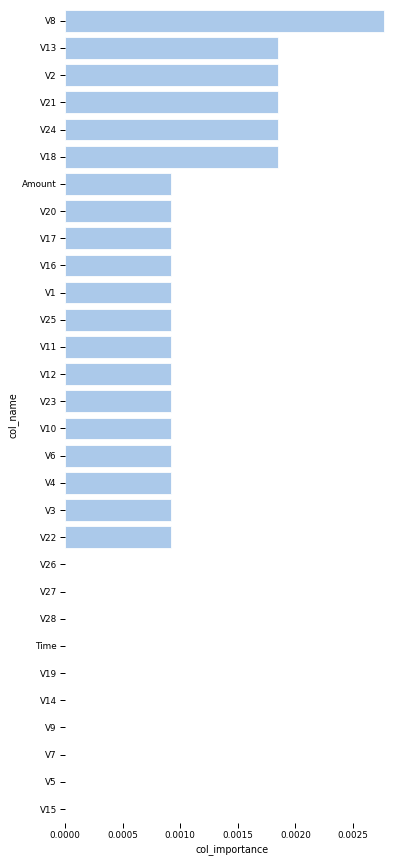

In [16]:
# 
imp_result_drop_acc = defaultdict(float)
for i,item in enumerate(col_list):
    imp_result_drop_acc[item] = abs(imp[i])
importance_plot(imp_result_drop_acc)

#### Log loss

In [17]:
## log_loss as metric
imp = dropcol_importances(model,X_train, y_train, X_valid, y_valid,log_loss,True)

[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6998029478945647
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.648254437122679e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.648254437122679e-07
[LightGBM] [Warning] lambda_l1 is set=7.902601989395657e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.902601989395657e-07
Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, colsample_bytree=1.0 will be ignored. Current valu

Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6998029478945647
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.648254437122679e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.648254437122679e-07
[LightGBM] [Warning] lambda_l1 is set=7.902601989395657e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.902601989395657e-07
Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, 

Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6998029478945647
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.648254437122679e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.648254437122679e-07
[LightGBM] [Warning] lambda_l1 is set=7.902601989395657e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.902601989395657e-07
Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, 

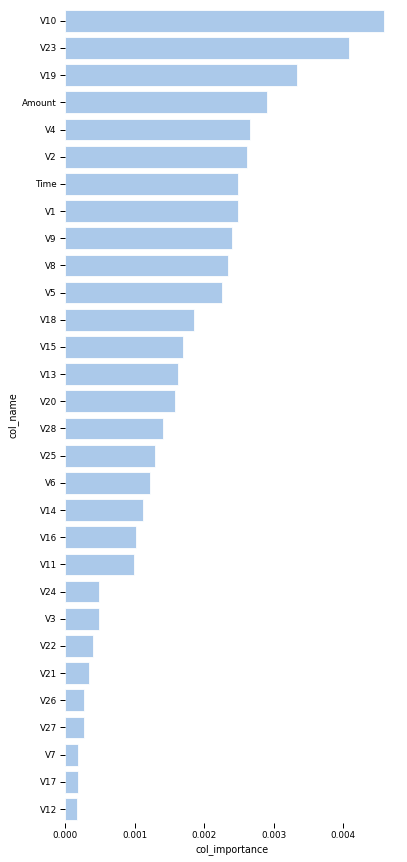

In [18]:
#
imp_result_drop_log = defaultdict(float)
for i,item in enumerate(col_list):
    imp_result_drop_log[item] = abs(imp[i])
importance_plot(imp_result_drop_log)

### Permutation Importance <a class="anchor" id="model2"></a>

#### Accuracy

In [19]:
model = lgb.LGBMClassifier(**param)
model.fit(X_train,y_train)

[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6998029478945647
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.648254437122679e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.648254437122679e-07
[LightGBM] [Warning] lambda_l1 is set=7.902601989395657e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.902601989395657e-07


LGBMClassifier(bagging_fraction=0.5584550389770908, bagging_freq=4,
               feature_fraction=0.6998029478945647,
               lambda_l1=7.902601989395657e-07, lambda_l2=5.648254437122679e-07,
               max_depth=5, metric='binary_logloss', min_child_samples=60,
               num_leaves=67, objective='binary', verbose=-1)

In [20]:
imp = permutation_importances(model, X_valid, y_valid,accuracy_score,proba = False)

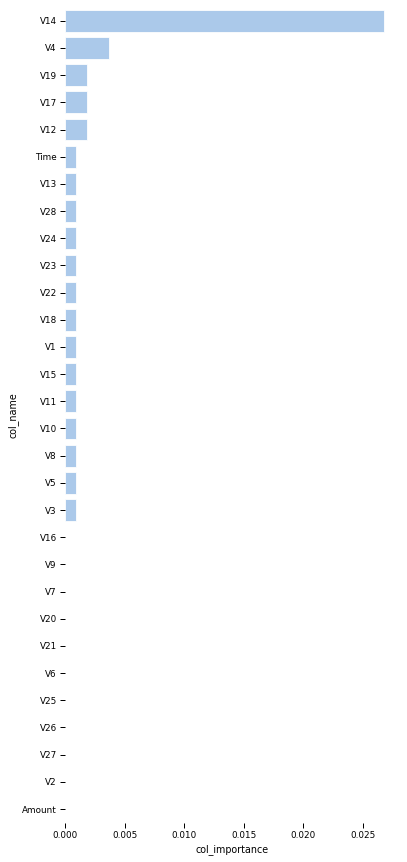

In [21]:
# 
imp_result_permutation_acc = defaultdict(float)
for i,item in enumerate(col_list):
    imp_result_permutation_acc[item] = abs(imp[i])
importance_plot(imp_result_permutation_acc)

#### Log loss

In [22]:
imp = permutation_importances(model, X_valid, y_valid,log_loss,proba = True)

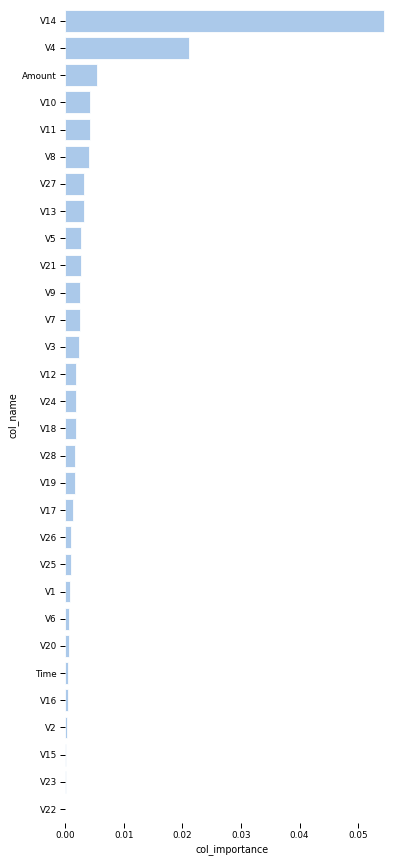

In [23]:
#
imp_result_permutation_log = defaultdict(float)
for i,item in enumerate(col_list):
    imp_result_permutation_log[item] = abs(imp[i])
importance_plot(imp_result_permutation_log)

### LightGBM Default Feature Importance <a class="anchor" id="model3"></a>

I also want to see the performance of LightGBM's default importance result. 

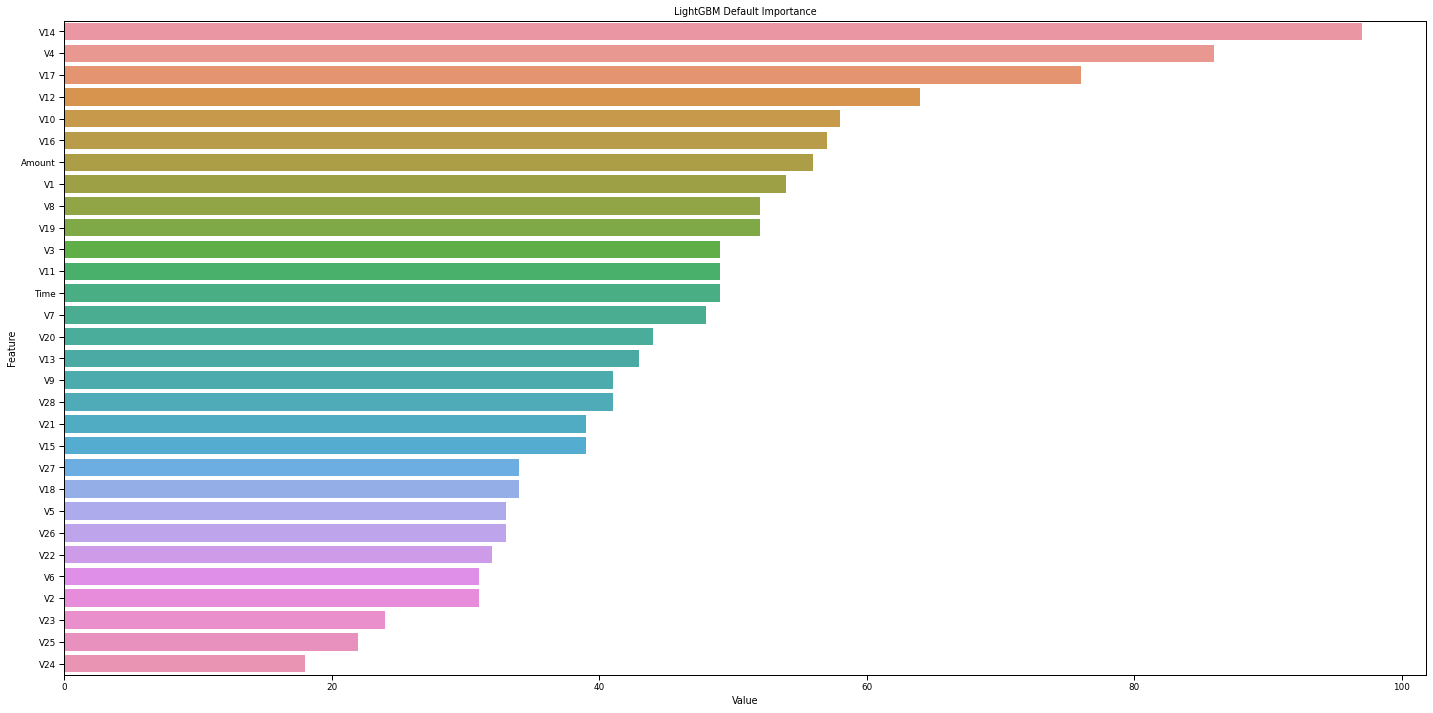

In [24]:
## LightGBM default feature importance
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Default Importance')
plt.tight_layout()
plt.show()

### SHAP <a class="anchor" id="model4"></a>

SHAP is the state of the art in Machine Learning explainability. It also has feature importance output.

In [36]:
#shap.initjs()
shap_values = shap.TreeExplainer(model).shap_values(X_valid)

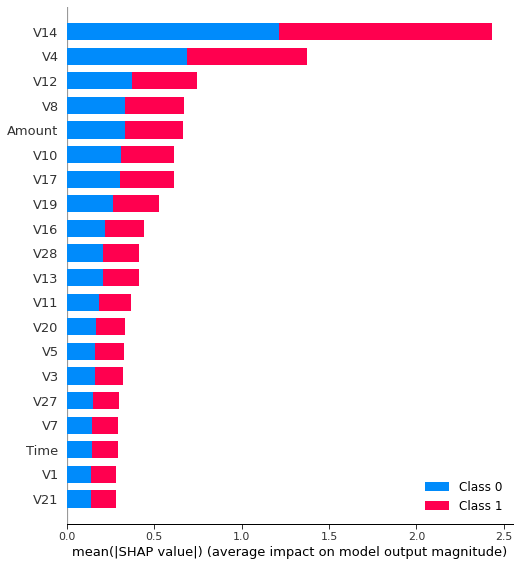

In [26]:
shap.summary_plot(shap_values, X_valid)

In [27]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance

,col_name,feature_importance_vals
14,V14,1317.113029
4,V4,745.368070
12,V12,402.238080
8,V8,361.554340
29,Amount,360.981563
10,V10,332.565777
17,V17,331.064427
19,V19,284.044797
16,V16,238.635295
28,V28,224.174521


# Feature Importance Comparison <a class="anchor" id="compare"></a>

* Spearman: importance_spearman
* PCA: importance_pca
* mRMR: importance_mRMR
* Drop Column Importance with accuracy: imp_result_drop_acc
* Drop Column Importance with log loss: imp_result_drop_log
* Permutation Importance with accuracy: imp_result_permutation_acc
* Permutation Importance with log loss: imp_result_permutation_log
* LightGBM default: feature_imp
* Shap: feature_importance

In [29]:
importance_spearman_order = get_order_from_imp_dict(importance_spearman)
importance_pca_order = get_order_from_imp_dict(importance_pca)
importance_mRMR_order = get_order_from_imp_dict(importance_mRMR)
importance_drop_acc_order = get_order_from_imp_dict(imp_result_drop_acc)
importance_drop_log_order = get_order_from_imp_dict(imp_result_drop_log)
importance_permutation_acc_order = get_order_from_imp_dict(imp_result_permutation_acc)
importance_permutation_log_order = get_order_from_imp_dict(imp_result_permutation_log)
importance_lgbm_defualt = list(feature_imp.Feature)[::-1]
importance_shap_defualt = list(feature_imp.Feature)

In [31]:
imp_spearman_loss = loss_feature_lgbm(X_train,y_train,importance_spearman_order)
imp_pca_loss = loss_feature_lgbm(X_train,y_train,importance_pca_order)
imp_mRMR_loss = loss_feature_lgbm(X_train,y_train,importance_mRMR_order)
imp_drop_acc_loss = loss_feature_lgbm(X_train,y_train,importance_drop_acc_order)
imp_drop_log_loss = loss_feature_lgbm(X_train,y_train,importance_drop_log_order)
imp_permutation_acc_loss = loss_feature_lgbm(X_train,y_train,importance_permutation_acc_order)
imp_permutation_log_loss = loss_feature_lgbm(X_train,y_train,importance_permutation_log_order)
imp_lgbm_loss = loss_feature_lgbm(X_train,y_train,importance_lgbm_defualt)
imp_shap_loss = loss_feature_lgbm(X_train,y_train,importance_shap_defualt)

In [32]:
num_features = list(range(1,9))
data_preproc = pd.DataFrame({
    'Number of Feature': num_features, 
    'Spearman Loss': imp_spearman_loss,
    'PCA Loss': imp_pca_loss,
    'mRMR Loss': imp_mRMR_loss,
    'Drop Column Accuracy Loss': imp_drop_acc_loss,
    'Drop Column Log Loss': imp_drop_log_loss,
    'Permutation Accuracy Loss': imp_permutation_acc_loss,
    'Permutation Log Loss':imp_permutation_log_loss,
    'LightGBM Default Loss':imp_lgbm_loss,
    'SHAP Loss':imp_shap_loss})

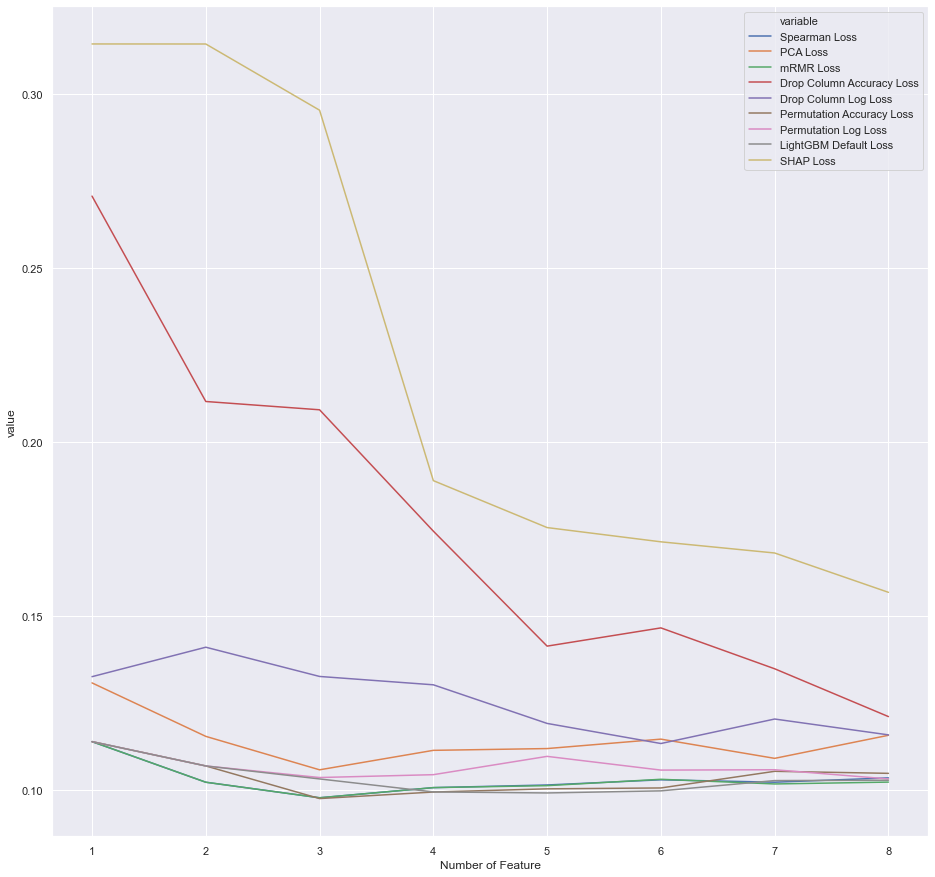

In [33]:
sns.set(rc={'figure.figsize':(15.7,15.27)})
sns.lineplot(x='Number of Feature', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['Number of Feature']))

This is just a initial attempt to see which feature importance method is good, the comparision is actually sensitive to model's parameter. From plot we notice: 
* The best feature importance search methods are <b>LightGBM default feature importance</b>, <b>Permutation with Accuracy as Metric</b> and <b>mRMR feature importance</b>. 
* For <b>Drop Column</b> and <b>Permutation</b> methods, they are sensitive to evaluation metric. For <b>Drop Column</b>, log loss performs better than accuracy, <b>Permutation</b> with two different metrics have similar results.
* <b>Permutation</b> is better than <b>Drop Column</b>, maybe because <b>Drop Column</b> method's models are not fully tuned.
* <b>SHAP</b> is the worst for some reasons.

# Automatic Feature Searching <a class="anchor" id="automatic"></a>

Final choice: importance_mRMR_order

In [62]:
out_col, loss_list = automatic_feature_search(X,y,importance_mRMR_order)
print(f'Final columns selected:{out_col}')
print(f'Loss history:{loss_list}')

Final columns selected:Index(['V14', 'V12', 'V4', 'V11', 'V3', 'V10', 'V16', 'V17', 'V9', 'V7', 'V2',
       'V6', 'V1', 'V18', 'V21', 'V5', 'V27', 'V19', 'V8', 'V28', 'V20', 'V24',
       'V26', 'V13', 'V25'],
      dtype='object')
Loss history:[0.09856560867844771, 0.09770468524278716, 0.09681408621246848, 0.09832274538858035]


This is an automatic feature searching method built for LightGBM model using log loss. Start from full features then drop the column with lowest importance. If the validation metric becomes worse, stop dropping and output the final result.

LightGBM only discards 4 features.

# Conclusion <a class="anchor" id="Conclusion"></a>

Feature importance helps us select features, interpret the model. Sometimes business values is inside of the feature importance. When we are dealing with real-world business problems, feature importance should combine with business instinct to guide companie's strategies and actions.

What is best feature importance measurement? It seems do not have a "best" answer. Permutation method, mRMR and LightGBM's default importance have good performance from the experiment results. Whereas they might be the best for this particular dataset (classification). I would say the final <b>true solution</b> should always be experimental design (A/B testing).

# References <a class="anchor" id="References"></a>

* https://arxiv.org/pdf/1908.05376.pdf (mRMR)
* https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient
* https://github.com/slundberg/shap (SHAP)
* https://github.com/parrt/msds621/blob/master/lectures/feature-importance.pdf
* https://github.com/parrt/msds689/blob/master/projects/featimp/featimp.md
* https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30